#**5. Image Segmentation**#

**Image Segmentation**:

* In an image classification task, the network assigns a label (or class) to each input image.

* However, suppose you want to know the shape of that object, which pixel belongs to which object, etc. In this case, you need to assign a class to each pixel of the image—this task is known as **Image Segmentation**.

* A segmentation model returns much more detailed information about the image.

**Applications of Image Segmentation**:

  1. Medical imaging

  2. Self-Driving Cars

  3. Satellite Imaging and so on



* Here, we are using dataset from **Oxford-IIIT Pet Dataset (Parkhi et al, 2012)**.

* The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits).

* Each image includes the corresponding labels, and pixel-wise masks.

* The masks are class-labels for each pixel.

* Each pixel is given one of three categories:

     * Class 1: Pixel belonging to the pet.

     * Class 2: Pixel bordering the pet.

     * Class 3: None of the above/a surrounding pixel.


**Steps to be followed in this problem:**


  * **Step-1 : Importing Necessary Libraries**
  * **Step-2 : Download the Oxford-IIIT Pets dataset**
  * **Step-3 : Defining the Model**
  * **Step-4 : Training the Model**
  * **Step-5 : Making Predictions**
  * **Step-6 : Imbalanced classes and class weights**

**Input**:


* Here, we are using dataset from **Oxford-IIIT Pet Dataset (Parkhi et al, 2012)**.


* The dataset consists of images of **37 pet breeds, with 200 images per breed (~100 each in the training and test splits)**.



* Each image includes the corresponding labels, and pixel-wise masks.



* The masks are class-labels for each pixel.





**Output:**


* Predicted **Output segmented images** (i.e) True Mask and Predicted Mask for the input images.

##**Source Code**##

In [ ]:
pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-h3v0zu0c
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-h3v0zu0c
  Resolved https://github.com/tensorflow/examples.git to commit 0b14ce1c88537b94772cc99d995d936417be6f5d
  Preparing metadata (setup.py) ... done


**Step-1 : Importing Necessary Libraries**

In [ ]:
import tensorflow as tf

import tensorflow_datasets as tfds

from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

**Step-2: Download the Oxford-IIIT Pets dataset**

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

* The below class performs a simple augmentation by randomly-flipping an image.

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

* Now, Build the input pipeline by applying the augmentation after batching the inputs.

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

* Then, Visualize an image example and its corresponding mask from the dataset.

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

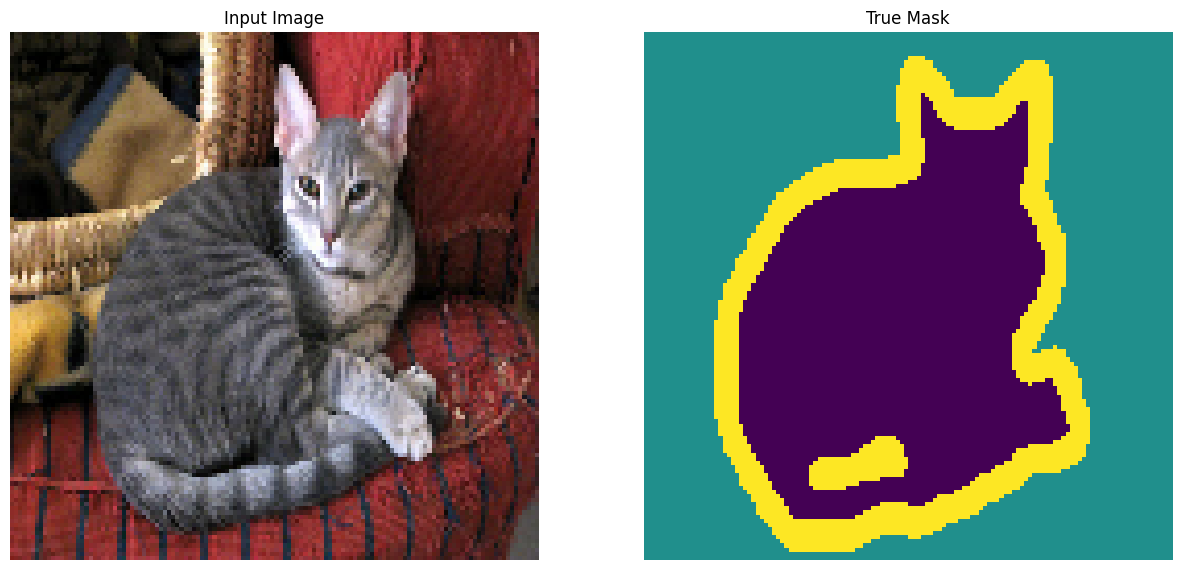

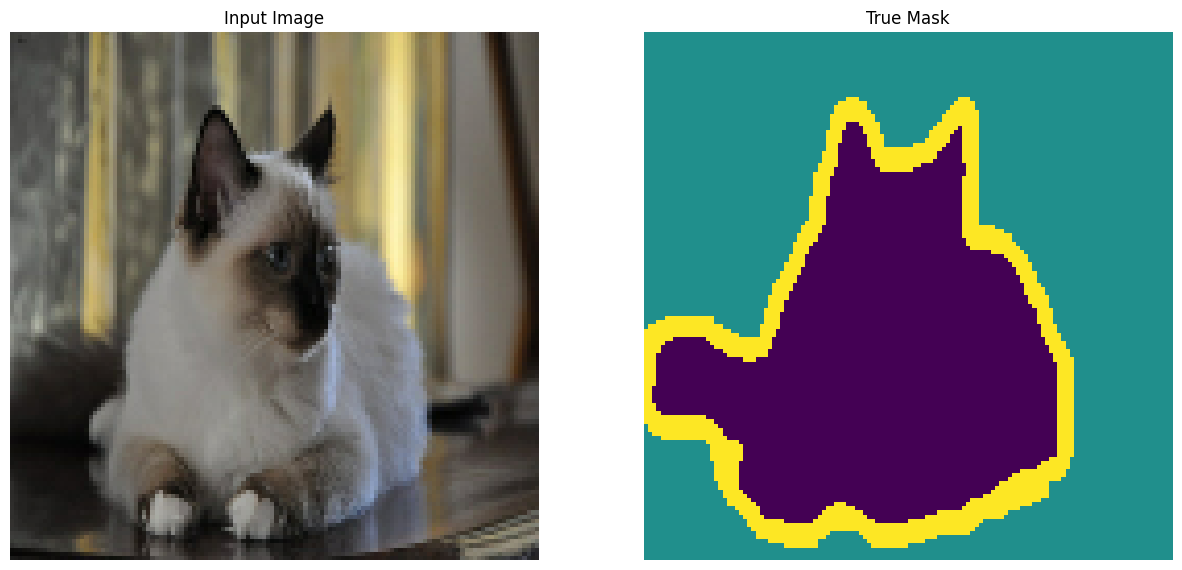

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

**Step-3: Defining the Model**


* The model used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler).

* To learn robust features and reduce the number of trainable parameters, use a pretrained model—MobileNetV2—as the encoder.

* For the decoder, we will use the upsample block, which is already implemented in the pix2pix example in the TensorFlow Examples repo.

* As mentioned, the encoder is a pretrained MobileNetV2 model. We will use the model from tf.keras.applications.

* The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

* The number of filters on the last layer is set to the number of output_channels. This will be one output channel per class.

**Step-4: Training the Model**

* Since this is a multiclass classification problem, we use the tf.keras.losses.SparseCategoricalCrossentropy loss function with the from_logits argument set to True, since the labels are scalar integers instead of vectors of scores for each pixel of every class.

* When running inference, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [ ]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

* Now, plotting the resulting model architecture

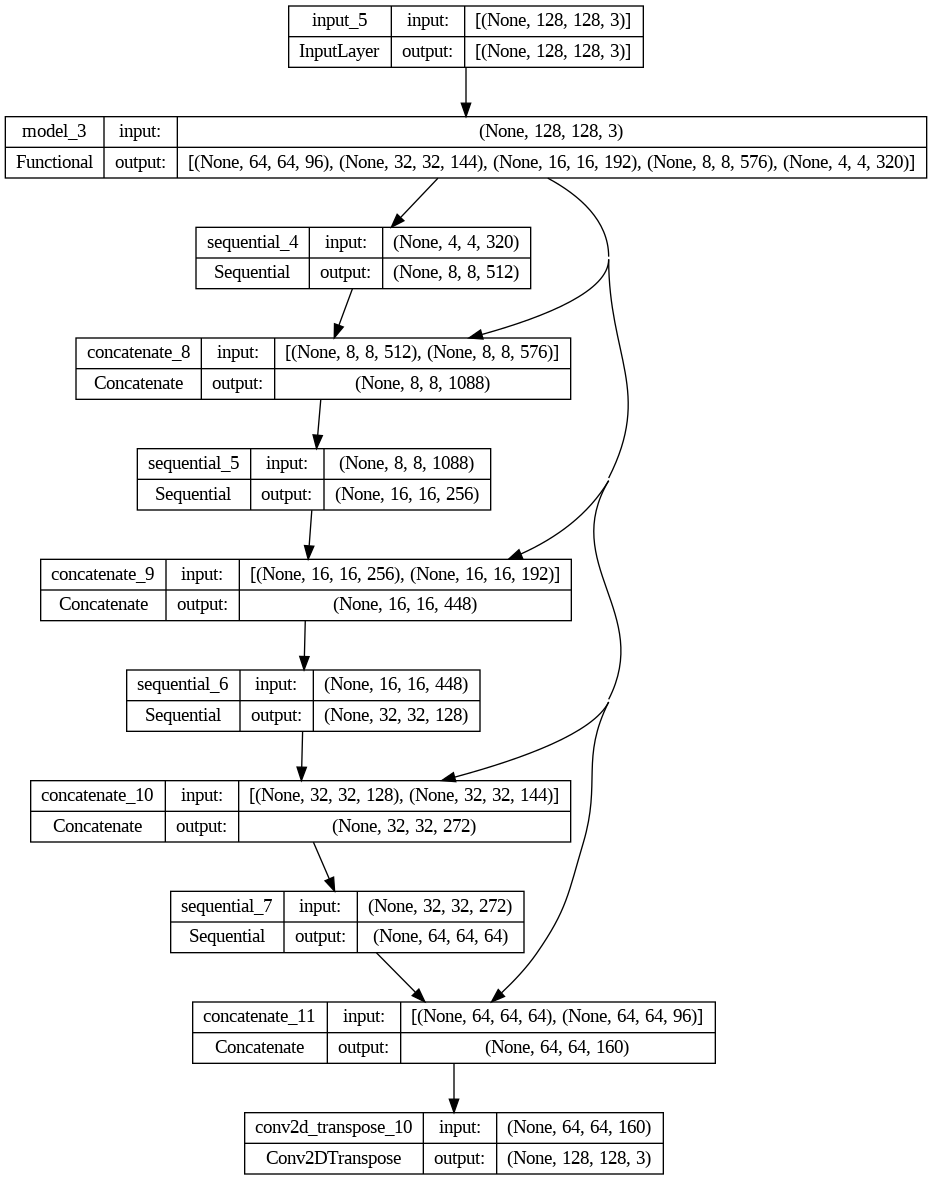

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

* Also, we also want to try out the model to check what it predicts before the training

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

1/1 [==============================] - 1s 1s/step


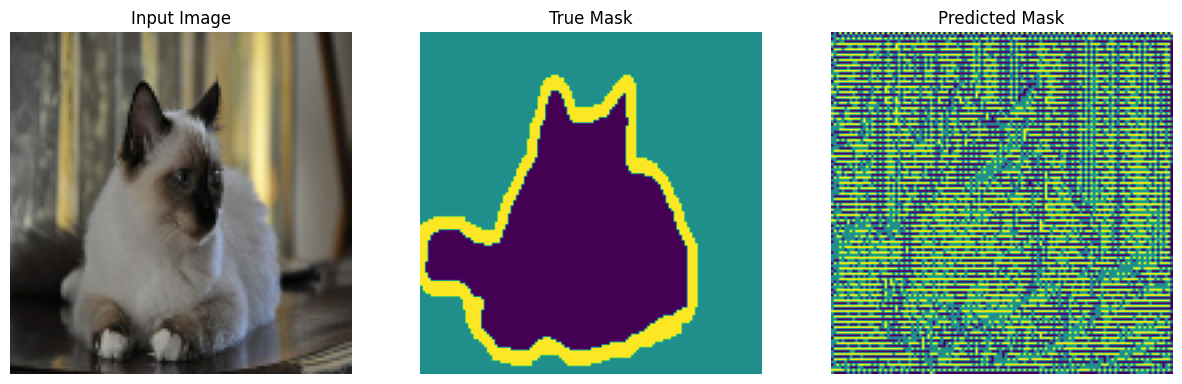

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

show_predictions()

* The callback defined is used to observe how the model improves while it is training:

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

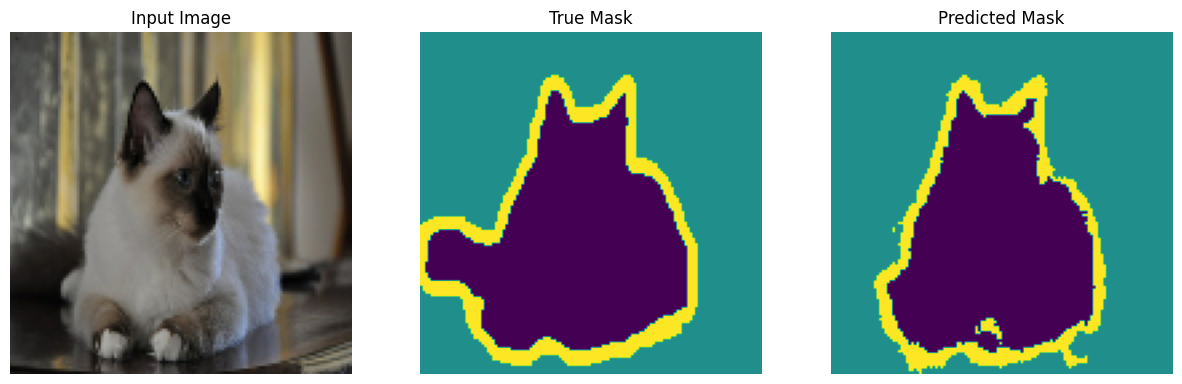


Sample Prediction after epoch 20

57/57 [==============================] - 358s 6s/step - loss: 0.1709 - accuracy: 0.9304 - val_loss: 0.2920 - val_accuracy: 0.8990


In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

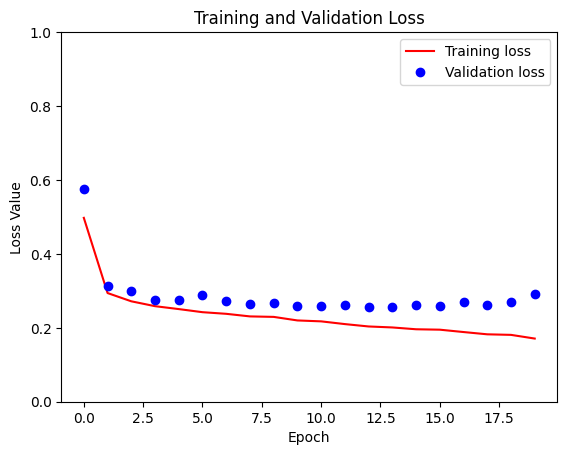

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

**Step-5: Making Predictions**
* Here, we will be making some predictions
* we can keep the number of epochs higher to achieve results with more accuracy.

2/2 [==============================] - 6s 3s/step


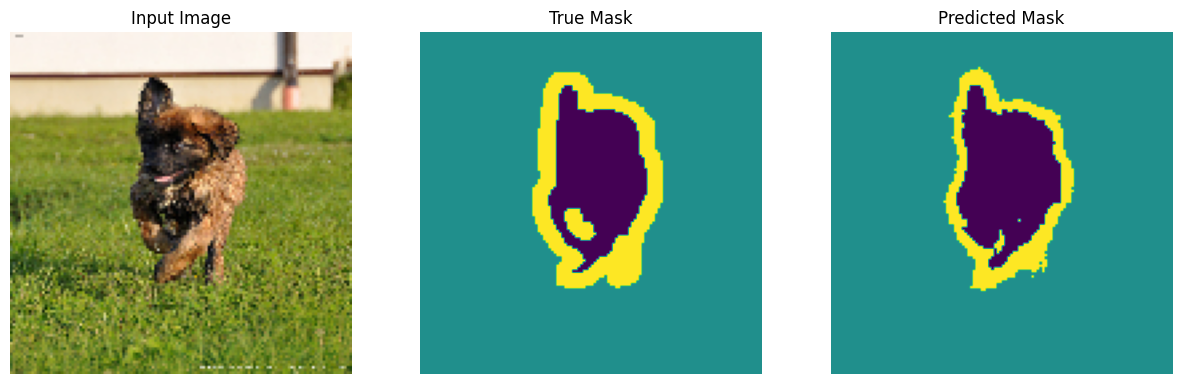

2/2 [==============================] - 7s 3s/step


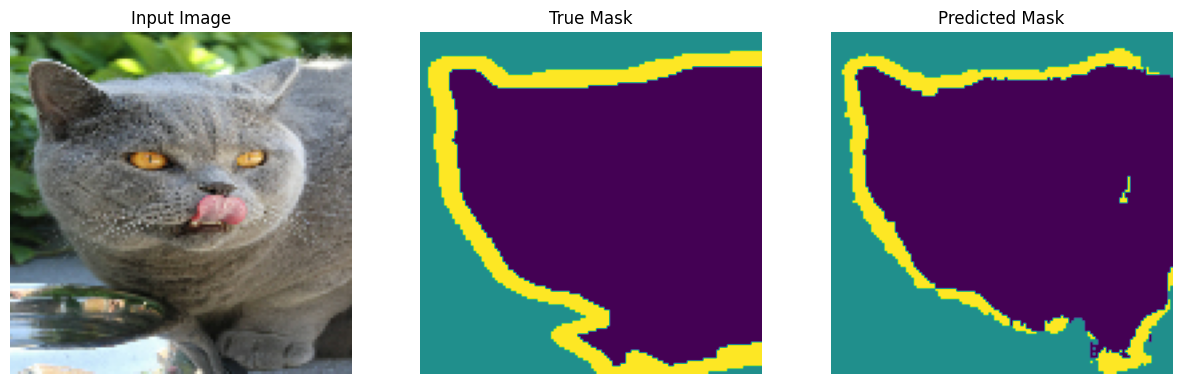

2/2 [==============================] - 7s 3s/step


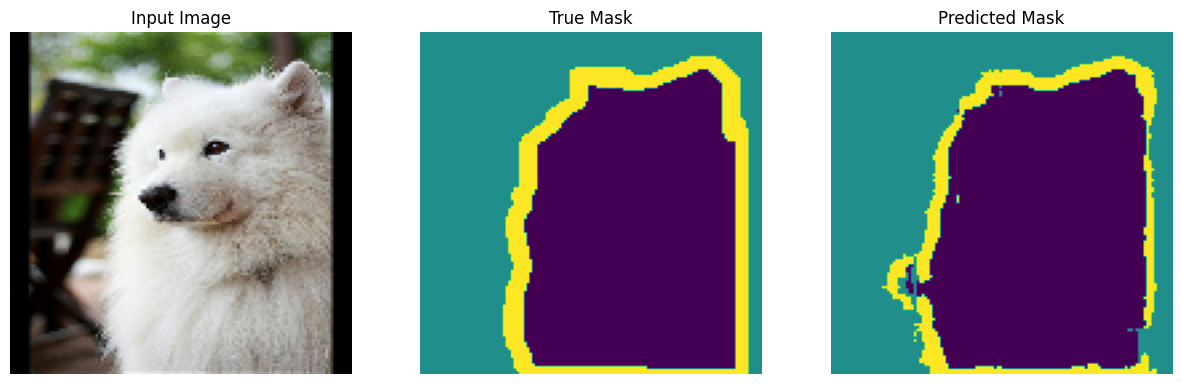

In [ ]:
show_predictions(test_batches, 3)

**Step-6: Imbalanced classes and class weights**

In [ ]:
try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

Epoch 1/20
57/57 [==============================] - 345s 6s/step - loss: 0.2618 - accuracy: 0.9212
Epoch 2/20
57/57 [==============================] - 338s 6s/step - loss: 0.2558 - accuracy: 0.9226
Epoch 3/20
57/57 [==============================] - 319s 6s/step - loss: 0.2401 - accuracy: 0.9263
Epoch 4/20
57/57 [==============================] - 321s 6s/step - loss: 0.2335 - accuracy: 0.9279
Epoch 5/20
57/57 [==============================] - 320s 6s/step - loss: 0.2251 - accuracy: 0.9302
Epoch 6/20
57/57 [==============================] - 319s 6s/step - loss: 0.2203 - accuracy: 0.9312
Epoch 7/20
57/57 [==============================] - 322s 6s/step - loss: 0.2114 - accuracy: 0.9335
Epoch 8/20
57/57 [==============================] - 331s 6s/step - loss: 0.2000 - accuracy: 0.9368
Epoch 9/20
57/57 [==============================] - 320s 6s/step - loss: 0.1997 - accuracy: 0.9367
Epoch 10/20
57/57 [==============================] - 320s 6s/step - loss: 0.1929 - accuracy: 0.9387
Epoch 11/

* here we need to implement the weighting ourself. We will do this using sample weights: In addition to (data, label) pairs, Model.fit also accepts (data, label, sample_weight) triples.

* Keras Model.fit propagates the sample_weight to the losses and metrics, which also accept a sample_weight argument. The sample weight is multiplied by the sample's value before the reduction step.

In [ ]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]]
sample_weight = [1, 10]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.keras.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

array([ 3.0485873, 30.485874 ], dtype=float32)

* We need a function that takes a (data, label) pair and returns a (data, label, sample_weight) triple where the sample_weight is a 1-channel image containing the class weight for each pixel.

* The simplest possible implementation is to use the label as an index into a class_weight list:

In [ ]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

* The output dataset elements contains 3 images each

In [ ]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

* Finally, we can train the data on this weighted dataset

In [ ]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [ ]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)

10/10 [==============================] - 67s 6s/step - loss: 0.3156 - accuracy: 0.6025
